The goal of this notebook is to demonstrate how we estimate the ENL for future notebooks which is related to the speckle noise model. We compute this in the simplest possible way, namely using the formula

$$
\frac{ E^2_{\textrm{Window}}(I)}{V_{\textrm{Window}}(I)}
$$
But there are more sophisticated methods found in:

+ https://github.com/WeiyingZhao/Multitemporal-SAR-image-denoising
+ https://www.theses.fr/2019SACLT003

In [1]:
import rasterio
import numpy
import scipy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from rabasar import get_enl_img, get_enl_mode, get_enl_mask
import json

# Data Paths

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'uavsar', 'site': 'waxlake', 'regularizer': 'tv'}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

In [4]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
if REGULARIZER != 'tv':
    data_dir_path_name += '_tv'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

# Specifying Slice Indices for a Subset

These are in the matrix coordinates `(row, col)` or `(i, j)`.

In [5]:
ts_index = 1
SLICE_INDEX = 1

In [6]:
if SITE == 'waxlake' and SENSOR == 'uavsar':
    if SLICE_INDEX == 0:
        sy = np.s_[:1000]
        sx = np.s_[:1000]
    elif SLICE_INDEX == 1:
        sy = np.s_[-1600:-1000]
        sx = np.s_[-3000:-1000]
else:
    raise NotImplementedError

This is the plot directory.

In [7]:
PLOT_DIR_NAME = f'plots/effective_number_of_looks_{SLICE_INDEX}'
PLOT_DIR = Path(PLOT_DIR_NAME)
PLOT_DIR.mkdir(exist_ok=True, parents=True)

# Opening data

In [28]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))
dem_path = DATA_DIR/'dem.tif'
assert(dem_path.exists())

hv_paths

[PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190620.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190701.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190716.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190725.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190812.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190923.tif'),
 PosixPath('uavsar_waxlake/data_reprojected/hv/uavsar_waxlake_hv_RTC_20190930.tif')]

In [ ]:
We are only going to determine the ENL using a subset. Change the slices Above.

In [9]:
with rasterio.open(hh_paths[ts_index]) as ds:
    hh = ds.read(1)[sy, sx] 
    profile = ds.profile
    
with rasterio.open(hv_paths[ts_index]) as ds:
    hv = ds.read(1)[sy, sx] 
    profile = ds.profile
    
with rasterio.open(vv_paths[ts_index]) as ds:
    vv = ds.read(1)[sy, sx] 
    profile = ds.profile
    
with rasterio.open(dem_path) as ds:
    dem = ds.read(1)[sy, sx]
    dem_profile = ds.profile
    dem_trans = ds.transform

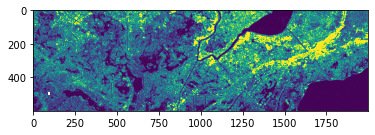

In [10]:
plt.imshow(hh, vmin=0, vmax=.5)

# Using the DEM to Exclude Slope

This is important for SAR in which slope can influence backscatter returns. We remove areas above a certain slope threshold.

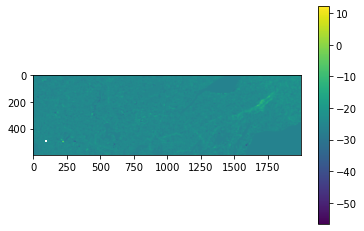

In [11]:
plt.imshow(dem)
plt.colorbar()

In [12]:
dx, dy = dem_trans.a, -dem_trans.e
dx, dy

(0.0001, 0.0001)

In [13]:
def haversine_np(p1, p2):
    """
    Source: https://stackoverflow.com/a/29546836
    
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = p1
    lon2, lat2 = p2
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


def get_dem_slope(dem, profile):
    """Author: Michael Denbina; adapted for rasterio"""
    trans = profile['transform']
    dx, dy = trans.a, -trans.e
    
    # The DEM is in meters so we need to determine the approximate
    # Resolution in Meters to compute the slope correctly.
    if profile['crs']['init'] == 'epsg:4326':
        origin = trans.c, trans.f
        origin_p_dx = trans.c + dx, trans.f
        origin_p_dy = trans.c, trans.f - dy
        # Convert to meters from km
        dx = haversine_np(origin, origin_p_dx) * 1000
        dy = haversine_np(origin, origin_p_dy) * 1000
    
    (nabla_y, nabla_x) = np.gradient(dem, dy, dx)
    print(dy, dx)
    slope = np.degrees(np.arctan(np.sqrt(nabla_y**2 + nabla_x**2)))
    return slope

11.112511347560305 9.660523430995298


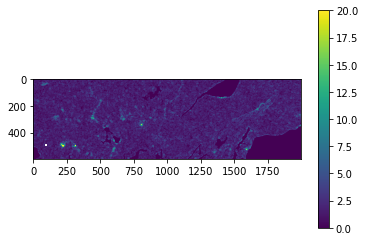

In [14]:
slope = get_dem_slope(dem, dem_profile)
plt.imshow(slope, vmax=20)
plt.colorbar()

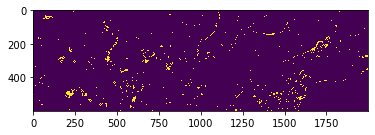

In [15]:
slope_mask = (slope > 5)
plt.imshow(slope_mask, interpolation='none')

# Making an ENL Mask

We are going to combine our slope mask with an additional mask where we exlcude all areas that are below -13 db (this very generously excludes non-vegetated areas in HH).

In [29]:
enl_mask = get_enl_mask(hh, 
                        db_min=-13, 
                        additional_mask=slope_mask)

Let's plot our mask.

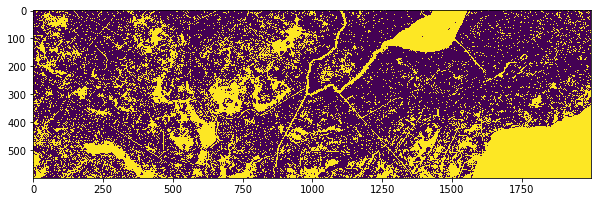

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(enl_mask, interpolation='none')

# Computing the ENL

In [18]:
enl_img = get_enl_img(hv, 21, enl_max=20, mask=enl_mask)

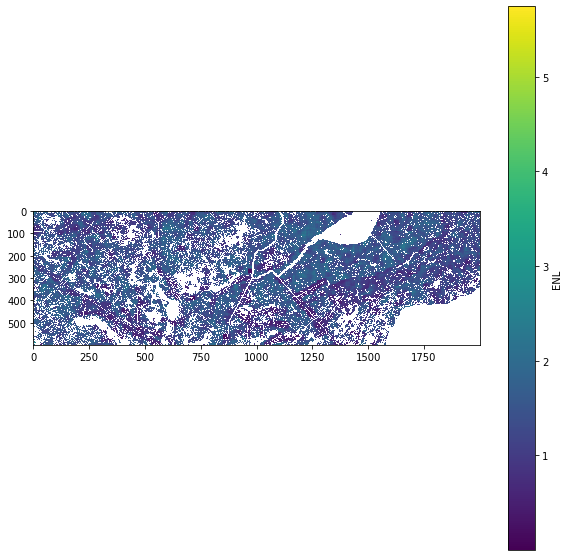

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(enl_img, interpolation='none')
fig.colorbar(im, label='ENL')

Text(0, 0.5, 'Density')

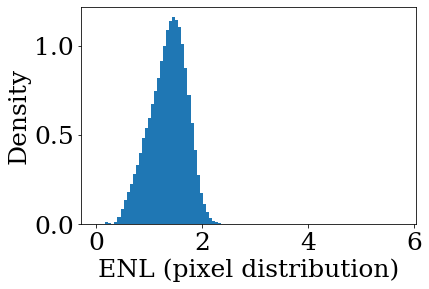

In [32]:
plt.hist(enl_img[~np.isnan(enl_img)], bins=100, density=True)
plt.xlabel('ENL (pixel distribution)')
plt.ylabel('Density')

Let's compute the mode. We have a simple routine that bins the values into 1, ..., 20 and determines the mode.

In [22]:
enl = get_enl_mode(enl_img, enl_min=1, enl_max=20)
enl

1.4

# Computing the ENL Across Window Sizes and Polarizations

We automate the investigation for slightly quicker inspection. The precise ENL is not as important as 

In [24]:
pol_dict = {'hh': hh,
            'hv': hv,
            'vv': vv
             }

In [ ]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=25)

In [25]:
def enl_winsize_exp(N, pol='hv'):
    
    img = pol_dict[pol]
    enl_img = get_enl_img(img, 21, enl_max=20, mask=enl_mask)
    enl = get_enl_mode(enl_img)
    fig, ax = plt.subplots(1, 3, figsize=(40, 10))
    
    im = ax[0].imshow(img, vmin=0, vmax=1)
    ax[0].set_title(pol.upper())
    fig.colorbar(im, ax=ax[0], label='$\gamma^0$')
    
    im = ax[1].imshow(enl_img, interpolation='none')
    ax[1].set_title(f'ENL, Window_size = {N}')
    fig.colorbar(im, ax=ax[1], label='ENL')
    
    ax[2].hist(enl_img[~np.isnan(enl_img)], bins=100)
    ax[2].set_title('ENL')
    
    data = enl_img[~np.isnan(enl_img)]
    ax = ax[2]
    ax.text(.62, .3, f'Mode = {enl:1.1f}', transform=ax.transAxes)
    ax.text(.62, .25, f'mean = {data.mean():1.1f}', transform=ax.transAxes)
    ax.text(.62, .2, f'N = {data.size:,}', transform=ax.transAxes)
    ax.text(.62, .15, f'window size = {N:,}', transform=ax.transAxes)
    
    dest_plot_dir = PLOT_DIR/f'enl_{pol}_timeindex={ts_index}'
    dest_plot_dir.mkdir(exist_ok=True, parents=True)
    plt.savefig(dest_plot_dir/f'windowsize={N}.png')
    plt.show()

In [26]:
window_sizes = [11, 21, 31, 41]

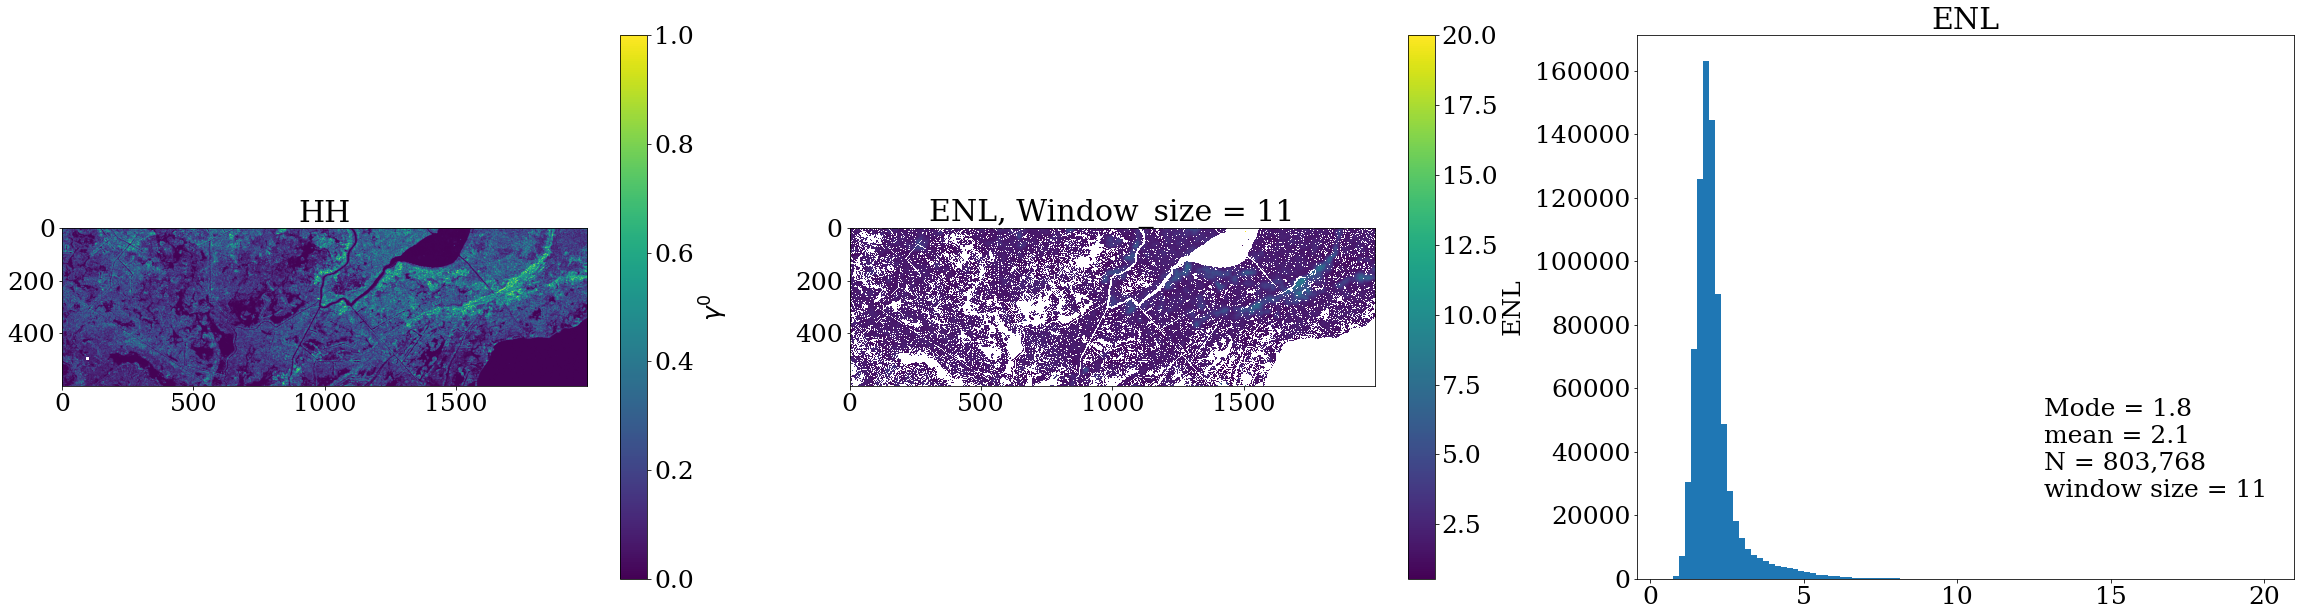

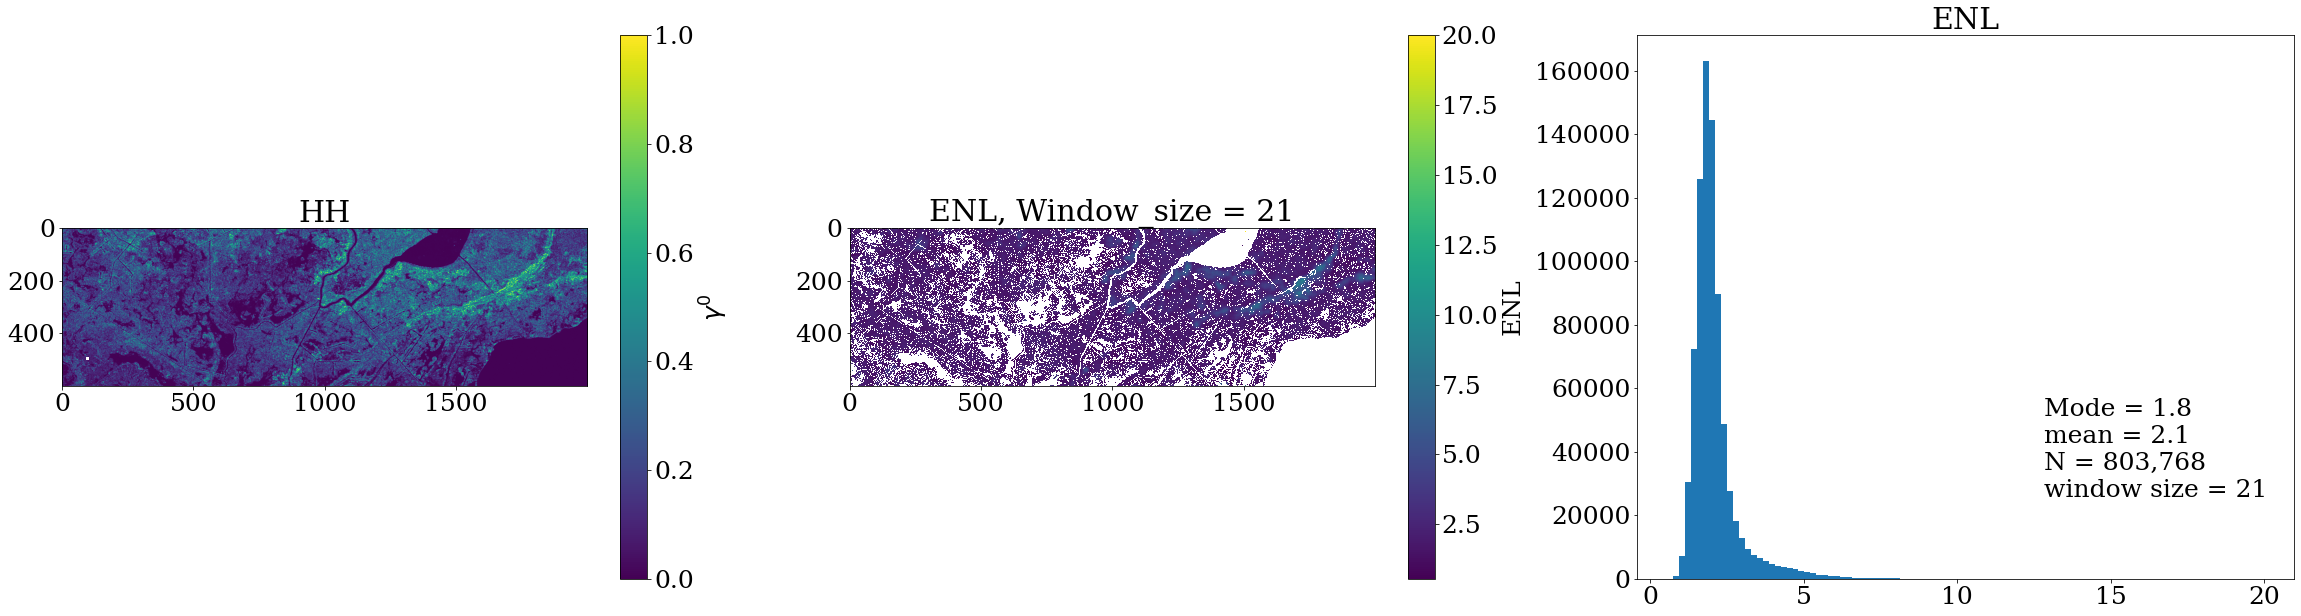

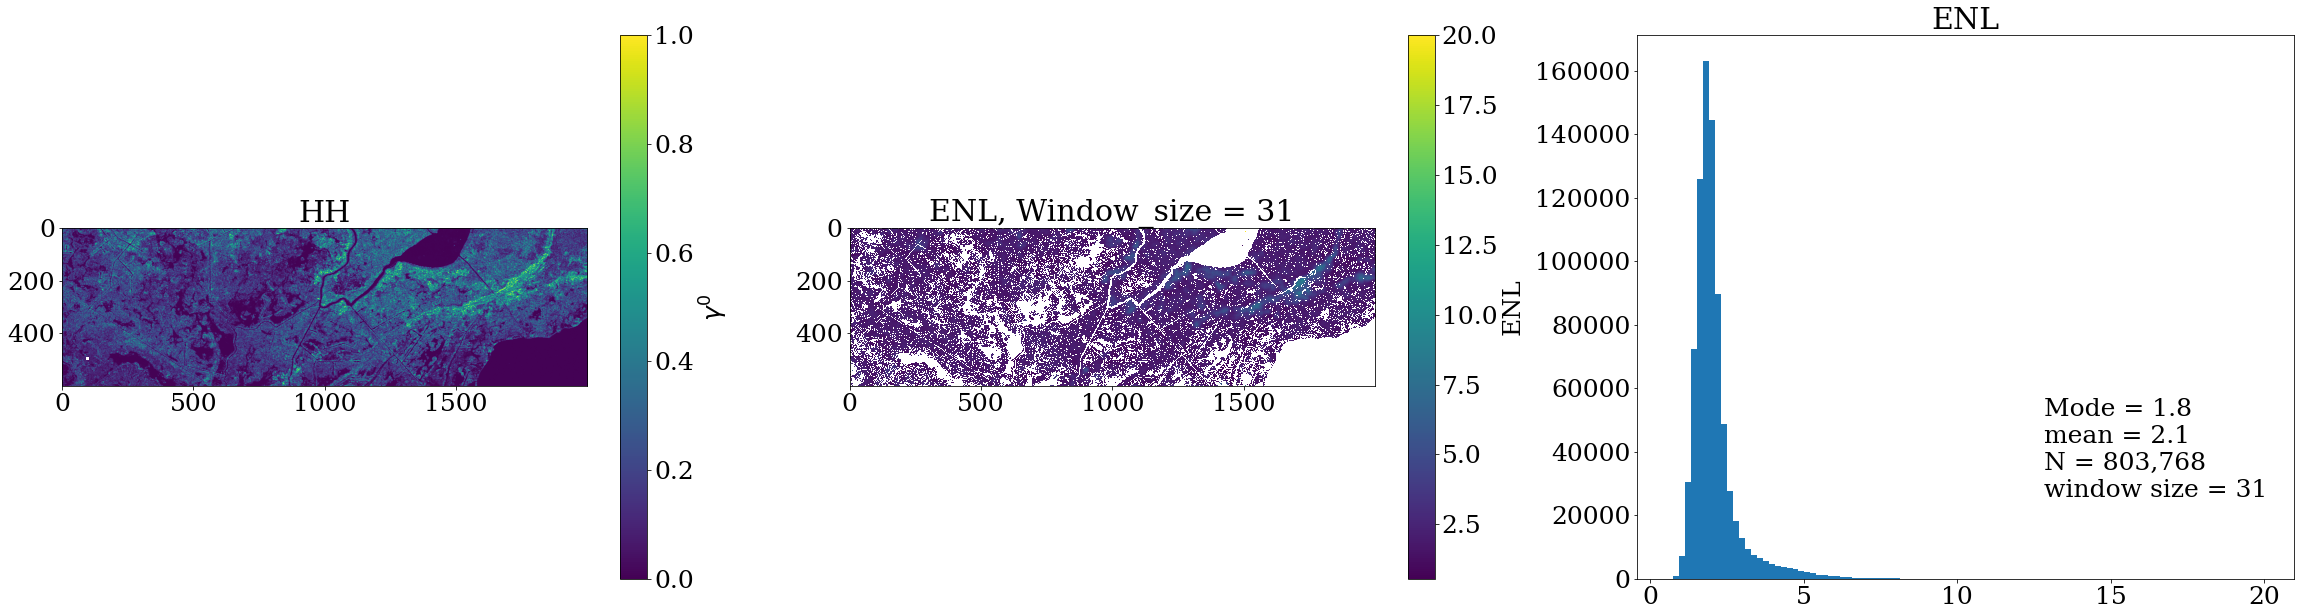

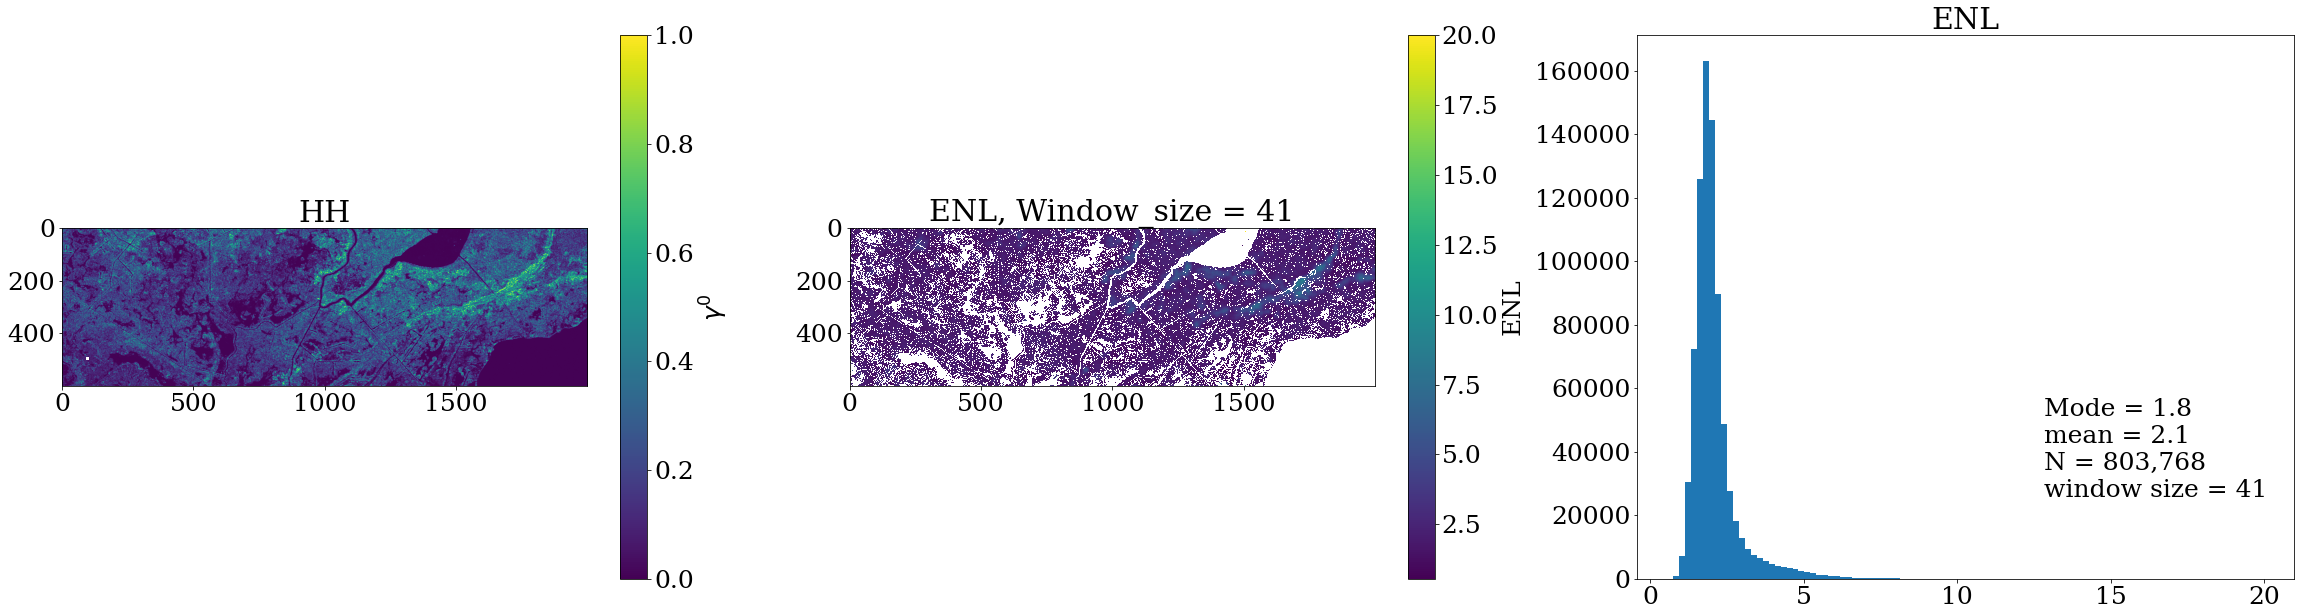

In [27]:
for N in window_sizes:
    enl_winsize_exp(N, pol='hh')  